**LANNELONGUE Vincent - GATIN Juliette**

# Projet numérique : lignes de niveau

## Imports préalables

In [20]:
pip install autograd

  Using cached https://files.pythonhosted.org/packages/23/12/b58522dc2cbbd7ab939c7b8e5542c441c9a06a8eccb00b3ecac04a739896/autograd-1.3.tar.gz
  Stored in directory: /Users/juliettegatin/Library/Caches/pip/wheels/42/62/66/1121afe23ff96af4e452e0d15e68761e3f605952ee075ca99f
Successfully built autograd
Note: you may need to restart the kernel to use updated packages.


In [31]:
import autograd
import numpy as np
import matplotlib.pyplot as plt

**Quelques fonctions f à tester :**

In [32]:
def f(x, y):
    return x**4 + y**4 -(x*y)**2
    #return np.power(x,2) + np.power(y,2)
    #return y**3 - x**2 

**Module permettant de visionner les lignes de niveaux théoriques :** 

<a list of 9 text.Text objects>

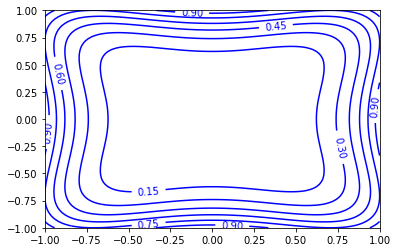

In [33]:
x, y = np.meshgrid(np.linspace(-1,1,101), np.linspace(-1,1,101))
z = f(x,y)
graphe = plt.contour(x,y,z,colors='blue')
plt.clabel(graphe,inline=1, fontsize=10, fmt='%3.2f')

**Fonction retournant le gradient :**

In [37]:
def grad(f,x,y):
    g = autograd.grad
    return np.r_[g(f, 0)(x, y), g(f, 1)(x, y)]

## Contour simple

**Condition raisonnable :** on choisit c tel que  c $\in$ [f(0,0) , f(0,1)] (ou c $\in$ [f(0,1) , f(0,0)]) de sorte qu'il existe un t $\in$ [0,1] tel que f(0,t) = c

La fonction find_seed utilise une méthode de dichotomie et se base sur la condition précédemment énoncée.

In [38]:
def find_seed(g, c=0, eps=2**(-26)):                
    m = min(g(0.0,0.0), g(0.0,1.0))                 
    M = max(g(0.0,0.0), g(0.0,1.0))                 
    if c < m or c > M :             # On commence par tester la condition pour vérifier que notre valeur de c convient 
        return (None)               # Si elle n'est pas remplie, on renvoit None
    else:                           # On applique ensuite une simple dichotomie pour trouver notre graine
        a = 0.0 ; b = 1.0
        t = (a+b)/2
        while b-a > eps :
            if (g(0.0,a)-c)*(g(0.0,t)-c) < 0:
                b = t
            else :
                a = t
            t = (a+b)/2
    return float(t)

**1ère version de simple_contour :** Cette première version fournit de manière très approchée, sans correction, les lignes de niveau. On se place au point d'indice n, on calcule le gradient en ce point. La propriété *le gradient est orthogonal à la ligne de niveau* permet de trouver une tangente à la ligne de niveau à partir de gradient. On choisit ensuite le point d'indice n+1  sur la droite tangente, espacé d'une distance $\delta$.

In [39]:
def simple_contour_1(f, c=0, delta=0.01):
    t = find_seed(f, c)                                      # On commence par trouver le 1er point de la ligne de niveau avec find_seed
    X = []                                              
    Y = []
    x = 0.0
    y = t
    N = 0
    if t == None :
        return (np.array(X), np.array(Y))
    else :
        while 0 <= x <= 1 and 0 <= y <= 1 and N <= 10000:   # Notre boucle s'arrête si la ligne de niveau sort du carré 
            X.append(x)                                         
            Y.append(y)
            g = grad(f,x,y)                                 # On calcule le gradient à notre point pour en déduire une tangente à la ligne de niveau
            normal = delta/np.sqrt(g[0]**2 + g[1]**2)       # normal est le facteur de normalisation par lequel on va multiplier notre vecteur déplacement
            vect = np.array([-g[1]*normal, g[0]*normal])    # 'vect' est le vecteur à ajouter ànotre point pour se déplacer le long de la tangente à la ligne de niveau
            x = x - vect[0]                                 # On trouve notre nouveau point en ajoutant 'vect' à  notre ancien point 
            y = y - vect[1] 
            N+=1 
    return (np.array(X), np.array(Y))                       # On renvoie les coordonnées des points de la ligne de niveau

**Affichage renvoyé par simple_contour_1**

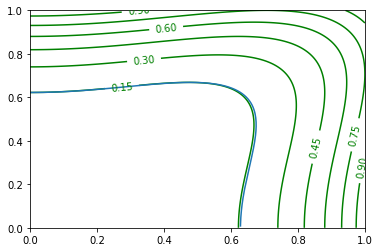

In [45]:
c = 0.15
X, Y = simple_contour_1(f, c)
x, y = np.meshgrid(np.linspace(0,1,1000), np.linspace(0,1,1000))
z = f(x,y)
graphe = plt.contour(x,y,z,colors='green')
plt.clabel(graphe,inline=1, fontsize=10, fmt='%3.2f')
plt.plot(X,Y)
plt.show()

**2ème version de simple_contour :** Version de simple_contour_1 avec une correction. Par définition, le gradient pointe vers la plus grande pente, on se sert donc de la valeur du gradient au point temporaire, fourni par la première version, pour obtenir un point plus satisfaisant. On réitère le procédé pour que la correction soit meilleure.

[id]: t.jpg "title" 

In [41]:
def simple_contour_2(f, c=0, delta=0.01, eps=0.000001):
    t = find_seed(f, c)
    X = []
    Y = []
    x = 0.0
    y = t
    N = 0
    if t == None :
        return (np.array(X), np.array(Y))
    else :
        while 0 <= x <= 1 and 0 <= y <= 1 and N <= 10000:
            X.append(x)
            Y.append(y)
            g = grad(f,x,y)
            normal = delta/np.sqrt(g[0]**2 + g[1]**2)
            vect = np.array([-g[1]*normal, g[0]*normal])            # Même démarche que dans la 1ère version, on trouve le point sur la ligne tangente à delta du précédent
            xbis = x - vect[0]                                      # On note 'bis' les coordonnées et le gradient du point provisoire (sur la tangente)
            ybis = y - vect[1]
            cbis = f(xbis, ybis) 
            gbis = grad(f, xbis, ybis)
            Nbis = 0
            while abs(cbis - c)  > eps and Nbis <100:               # On cherche à se rapprocher de la ligne de niveau réelle jusqu'à atteindre une valeur correcte
                if cbis < c :                                       # On regarde si notre point est au dessus ou en dessous de la ligne de niveau réelle
                    xbis += gbis[0] * 0.0001                        # On corrige en remontant ou descentant la monte (selon s'il faut monter ou descendre)
                    ybis += gbis[1] * 0.0001                        # On se sert du gradient pour savoir vers où aller pour monter ou descendre (il indique la pente)
                if cbis > c :
                    xbis -= gbis[0] * 0.0001
                    ybis -= gbis[1] * 0.0001
                cbis = f(xbis, ybis)
                gbis = grad(f, xbis, ybis)
                Nbis+=1
            x = xbis                                                # Notre point final est donc celui corrigé
            y = ybis
            N+=1 
        return np.array(X), np.array(Y)

**Affichage renvoyé par simple_contour_2**

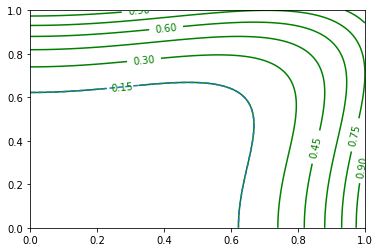

In [44]:
c = 0.15
X_, Y_ = simple_contour_2(f, c)
x, y = np.meshgrid(np.linspace(0,1,1000), np.linspace(0,1,1000))
z = f(x,y)

graphe = plt.contour(x,y,z,colors='green')
plt.clabel(graphe,inline=1, fontsize=10, fmt='%3.2f')
plt.plot(X_,Y_, '--')
plt.show()

**Comparaison des deux versions de simple contour :**

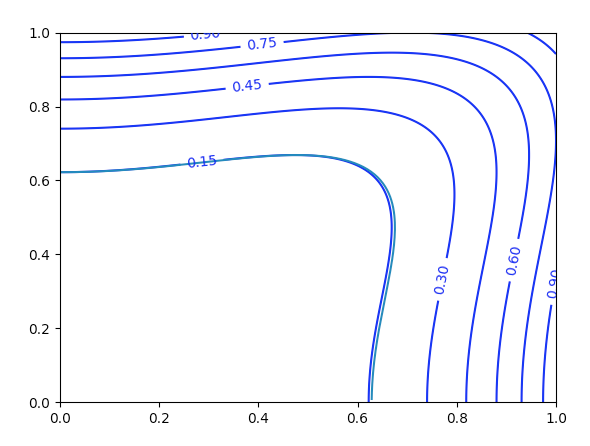

                                       -1ère version, f(x,y)=x**4 + y**4 -(x*y)**2- 

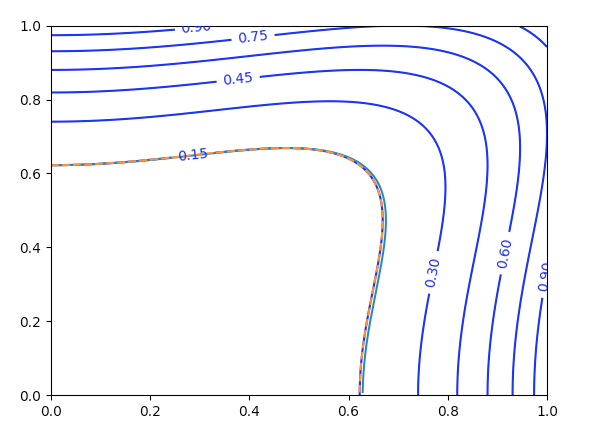


                                 -1ère & 2ème versions , f(x,y)=x**4 + y**4 -(x*y)**2-

## Contour complexe

**Pour contour complexe :**  utilisation du code déjà fourni

In [46]:
# Rotators
# ------------------------------------------------------------------------------
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function


# Complex Contouring
# ------------------------------------------------------------------------------

# Customize the simple_contour function used in contour :
# simple_contour = smart_simple_contour


def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour_2(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append((xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve))
    return curves

**Affichage renvoyé par contour**

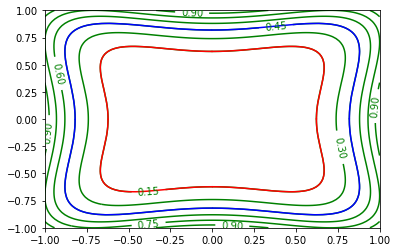

In [47]:
c1 = 0.15
c2 = 0.45
level_curves_1 = contour(f, c1, [-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0])
level_curves_2 = contour(f, c2, [-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0])
for x, y in level_curves_1:
    plt.plot(x,y, color='red')
for x, y in level_curves_2:
    plt.plot(x,y, color='blue')
x, y = np.meshgrid(np.linspace(-1,1,101), np.linspace(-1,1,101))
z = f(x,y)
graphe = plt.contour(x,y,z,colors='green')
plt.clabel(graphe,inline=1, fontsize=10, fmt='%3.2f')
plt.show()

**Quelques tracés :**

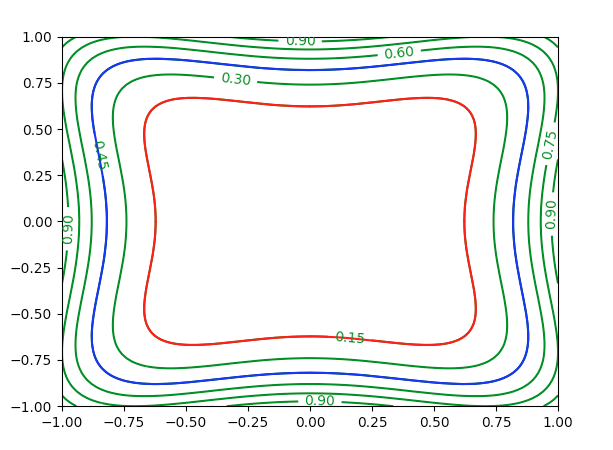

                                        -Tracé global de deux lignes de niveaux- 

**Un petit zoom :**

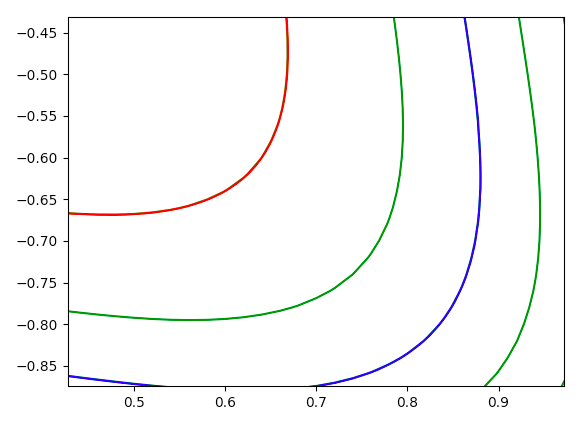

                                       -Zoom et tracé global de deux lignes de niveaux- 

## Un exemple  — f(x,y) = x^4 + y^4 -(x*y)^2